<a href="https://colab.research.google.com/github/titusjscott/multi-layer-perceptron/blob/main/current_airline_delay_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import keras
from keras.metrics import Precision, Recall
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
from kerastuner.tuners import RandomSearch

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/titusjscott/multi-layer-perceptron/main/airlines_delay.csv")


In [5]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [6]:
df.isna().sum()

Flight         0
Time           0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Class          0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539382 entries, 0 to 539381
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Flight       539382 non-null  float64
 1   Time         539382 non-null  float64
 2   Length       539382 non-null  float64
 3   Airline      539382 non-null  object 
 4   AirportFrom  539382 non-null  object 
 5   AirportTo    539382 non-null  object 
 6   DayOfWeek    539382 non-null  int64  
 7   Class        539382 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 32.9+ MB


In [8]:
df.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443
std,2067.431700,278.045546,70.117045,1.914666,0.497015
min,1.000000,10.000000,0.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


<AxesSubplot:xlabel='Class', ylabel='count'>

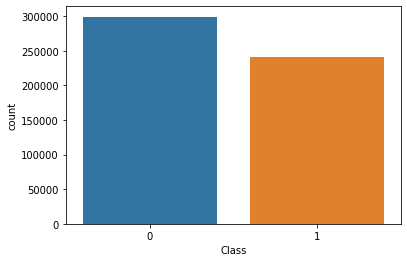

In [9]:
sns.countplot(df['Class'], label = "Count")

In [10]:
df['Class'].value_counts()

0    299118
1    240264
Name: Class, dtype: int64

In [11]:
df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [12]:
df = df.iloc[:,1:]

In [13]:
df.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,1296.0,141.0,DL,ATL,HOU,1,0
1,360.0,146.0,OO,COS,ORD,4,0
2,1170.0,143.0,B6,BOS,CLT,3,0
3,1410.0,344.0,US,OGG,PHX,6,0
4,692.0,98.0,FL,BMI,ATL,4,0


In [14]:
print(df['Airline'].unique())

['DL' 'OO' 'B6' 'US' 'FL' 'WN' 'CO' 'AA' 'YV' 'EV' 'XE' '9E' 'OH' 'UA'
 'MQ' 'AS' 'F9' 'HA']


In [15]:
df['Airline'].value_counts()

WN    94097
DL    60940
OO    50254
AA    45656
MQ    36604
US    34500
XE    31126
EV    27983
UA    27619
CO    21118
FL    20827
9E    20686
B6    18112
YV    13725
OH    12630
AS    11471
F9     6456
HA     5578
Name: Airline, dtype: int64

In [16]:
#convert the airline codes to numeric value
le = LabelEncoder()
df['Airline_ID'] = le.fit_transform(df['Airline'])

scaler = MinMaxScaler(feature_range=(1, 18))
df['Airline_ID'] = scaler.fit_transform(df[['Airline_ID']])

In [17]:
print(df['Airline_ID'].unique())

[ 6. 13.  4. 15.  9. 16.  5.  2. 18.  7. 17.  1. 12. 14. 11.  3.  8. 10.]


In [18]:
df['Airline_ID'].value_counts()

16.0    94097
6.0     60940
13.0    50254
2.0     45656
11.0    36604
15.0    34500
17.0    31126
7.0     27983
14.0    27619
5.0     21118
9.0     20827
1.0     20686
4.0     18112
18.0    13725
12.0    12630
3.0     11471
8.0      6456
10.0     5578
Name: Airline_ID, dtype: int64

In [19]:
df['AirportFrom'].value_counts()

ATL    34449
ORD    24822
DFW    22153
DEN    19843
LAX    16657
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportFrom, Length: 293, dtype: int64

In [20]:
#convert the AirportFrom codes to numeric value
le = LabelEncoder()
df['AirportFrom_ID'] = le.fit_transform(df['AirportFrom'])

scaler = MinMaxScaler(feature_range=(1, 293))
df['AirportFrom_ID'] = scaler.fit_transform(df[['AirportFrom_ID']])

In [21]:
df['AirportFrom_ID'].value_counts()

17.0     34449
209.0    24822
81.0     22153
80.0     19843
155.0    16657
         ...  
190.0       16
260.0       15
126.0       10
9.0          9
4.0          2
Name: AirportFrom_ID, Length: 293, dtype: int64

In [22]:
df['AirportTo'].value_counts()

ATL    34440
ORD    24871
DFW    22153
DEN    19848
LAX    16656
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportTo, Length: 293, dtype: int64

In [23]:
#convert the AirportTo codes to numeric value
le = LabelEncoder()
df['AirportTo_ID'] = le.fit_transform(df['AirportTo'])

scaler = MinMaxScaler(feature_range=(1, 293))
df['AirportTo_ID'] = scaler.fit_transform(df[['AirportTo_ID']])

In [24]:
df['AirportTo_ID'].value_counts()

17.0     34440
209.0    24871
81.0     22153
80.0     19848
155.0    16656
         ...  
190.0       16
260.0       15
126.0       10
9.0          9
4.0          2
Name: AirportTo_ID, Length: 293, dtype: int64

In [25]:
a = df[['Airline', 'AirportFrom', 'AirportTo']]
df = df.drop(a, axis=1)


In [26]:
df.head(10)

,Time,Length,DayOfWeek,Class,Airline_ID,AirportFrom_ID,AirportTo_ID
0,1296.0,141.0,1,0,6.0,17.0,130.0
1,360.0,146.0,4,0,13.0,66.0,209.0
2,1170.0,143.0,3,0,4.0,36.0,61.0
3,1410.0,344.0,6,0,15.0,204.0,218.0
4,692.0,98.0,4,0,9.0,33.0,17.0
5,580.0,60.0,4,0,16.0,199.0,28.0
6,690.0,239.0,4,0,5.0,97.0,81.0
7,1210.0,80.0,3,0,2.0,81.0,178.0
8,1295.0,105.0,7,0,9.0,46.0,120.0
9,530.0,108.0,3,0,9.0,17.0,214.0


In [27]:
cols = list(df.columns)
cols = [cols[3]] + cols[:3] + cols[4:]
df = df[cols]
df.head()

,Class,Time,Length,DayOfWeek,Airline_ID,AirportFrom_ID,AirportTo_ID
0,0,1296.0,141.0,1,6.0,17.0,130.0
1,0,360.0,146.0,4,13.0,66.0,209.0
2,0,1170.0,143.0,3,4.0,36.0,61.0
3,0,1410.0,344.0,6,15.0,204.0,218.0
4,0,692.0,98.0,4,9.0,33.0,17.0


In [28]:
train, test = train_test_split(df, test_size=0.35, random_state = 40)
print("Training Data :", train.shape)
print("Testing Data :", test.shape)

Training Data : (350598, 7)
Testing Data : (188784, 7)


In [29]:
train.head()

,Class,Time,Length,DayOfWeek,Airline_ID,AirportFrom_ID,AirportTo_ID
263031,1,1063.0,118.0,7,14.0,154.0,80.0
97712,1,1330.0,292.0,7,15.0,155.0,217.0
536842,1,570.0,165.0,5,16.0,80.0,203.0
237511,0,650.0,620.0,1,6.0,17.0,129.0
261014,1,510.0,160.0,2,16.0,46.0,105.0


In [30]:
test.head()

,Class,Time,Length,DayOfWeek,Airline_ID,AirportFrom_ID,AirportTo_ID
309672,1,1152.0,77.0,1,7.0,17.0,116.0
386273,0,1180.0,79.0,7,6.0,178.0,199.0
350725,0,695.0,80.0,1,7.0,288.0,17.0
69486,0,925.0,110.0,3,11.0,286.0,209.0
417318,1,510.0,80.0,5,11.0,81.0,42.0


In [31]:
train_df_x = train.iloc[:,1:]
train_df_x = MinMaxScaler().fit_transform(train_df_x)

test_df_x = test.iloc[:,1:]
test_df_x = MinMaxScaler().fit_transform(test_df_x)

print(train_df_x.shape)
print(test_df_x.shape)

(350598, 6)
(188784, 6)


In [32]:
train_df_y = train.iloc[:,:1]
train_df_y = train_df_y.astype('float32')

test_df_y = test.iloc[:,:1]
test_df_y = test_df_y.astype('float32')

print(train_df_y)
print(test_df_y)

        Class
263031    1.0
97712     1.0
536842    1.0
237511    0.0
261014    1.0
...       ...
138911    1.0
200211    1.0
137031    0.0
114369    0.0
473253    1.0

[350598 rows x 1 columns]
        Class
309672    1.0
386273    0.0
350725    0.0
69486     0.0
417318    1.0
...       ...
368001    1.0
456113    0.0
80011     0.0
38202     1.0
190758    0.0

[188784 rows x 1 columns]


In [32]:
# Define the model builder function
class_weights = {
    0: 1.0,
    1: 1.15,
}

def build_model(hp):
    model = keras.Sequential()
    
    # Tune the number of neurons in the first hidden layer
    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
    
    model.add(layers.Dense(units=hp_units, activation='relu', input_shape=(6,), bias_initializer='random_normal'))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.add(layers.Dense(units=10, activation='relu', bias_initializer='random_normal'))
    model.add(layers.Dense(units=1, activation='sigmoid', bias_initializer='random_normal'))
    
    # Compile the model with binary cross-entropy loss and Adam optimizer, and add precision, recall, and F1 score to the metrics
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(hp_learning_rate), metrics=['accuracy', Precision(), Recall()])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    
    return model

# Initialize the random search tuner with the model builder function and the hyperparameter search space
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner_results',
    project_name='my_model')

# Search for the best hyperparameters
tuner.search(train_df_x, train_df_y, epochs=200, batch_size=750, class_weight=class_weights, validation_data=(test_df_x, test_df_y))

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Number of units in the first hidden layer: {}'.format(best_hps.get('units')))
print('Learning rate: {}'.format(best_hps.get('learning_rate')))


Trial 5 Complete [00h 33m 04s]
val_accuracy: 0.644837478796641

Best val_accuracy So Far: 0.644837478796641
Total elapsed time: 02h 32m 57s
Number of units in the first hidden layer: 448
Learning rate: 0.0001


In [45]:
class_weights = {
    0: 1.0,
    1: 1.1965,
}

model = tf.keras.Sequential([
    tf.keras.layers.Dense(448, activation='relu', input_shape = (6,), bias_initializer = 'random_normal'),
    tf.keras.layers.Dense(15, activation='relu', bias_initializer='random_normal'),
    tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer='random_normal')
])

In [46]:
# compile the model with binary cross-entropy loss and Adam optimizer, and add precision, recall score to the metrics
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy', Precision(), Recall()])
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)


# train the model using the training set
history = model.fit(train_df_x, train_df_y, epochs=500, batch_size=1000, class_weight=class_weights, validation_data=(test_df_x, test_df_y))

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_df_x, test_df_y, verbose=0)

# Print the results
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)

Epoch 1/500
351/351 [==============================] - 4s 7ms/step - loss: 0.7344 - accuracy: 0.5748 - precision_5: 0.5202 - recall_5: 0.5843 - val_loss: 0.6683 - val_accuracy: 0.5829 - val_precision_5: 0.5281 - val_recall_5: 0.5966
Epoch 2/500
351/351 [==============================] - 3s 8ms/step - loss: 0.7282 - accuracy: 0.5841 - precision_5: 0.5285 - recall_5: 0.6134 - val_loss: 0.6686 - val_accuracy: 0.5838 - val_precision_5: 0.5250 - val_recall_5: 0.6890
Epoch 3/500
351/351 [==============================] - 2s 7ms/step - loss: 0.7245 - accuracy: 0.5930 - precision_5: 0.5386 - recall_5: 0.6019 - val_loss: 0.6684 - val_accuracy: 0.5897 - val_precision_5: 0.5306 - val_recall_5: 0.6851
Epoch 4/500
351/351 [==============================] - 2s 6ms/step - loss: 0.7218 - accuracy: 0.5980 - precision_5: 0.5449 - recall_5: 0.5926 - val_loss: 0.6590 - val_accuracy: 0.6039 - val_precision_5: 0.5520 - val_recall_5: 0.5886
Epoch 5/500
351/351 [==============================] - 2s 6ms/step -

5900/5900 [==============================] - 7s 1ms/step
Confusion Matrix: 
[[71449 33240]
 [33870 50225]]


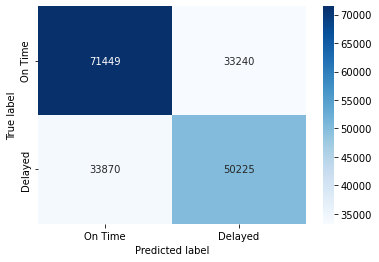

In [47]:
# predict classes for the test set
y_pred_prob = model.predict(test_df_x)
y_pred = (y_pred_prob > 0.5).astype(int)

# generate confusion matrix
cm = confusion_matrix(test_df_y, y_pred, labels=[0,1])

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])

plt.xlabel('Predicted label')
plt.ylabel('True label')

# print confusion matrix
print('Confusion Matrix: ')
print(cm)
plt.show()